In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
# (Agent's score , Dealer's visible score, and whether or not the agent has a usable ace)
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [4]:
# agent only has 2 options: Hit(1) or Stay(0).
env.action_space.n

2

In [5]:
env.reset()
print("Player's Hand: {}, \nDealer visible Hand: {}, \nUsable Ace: {}".format(env.reset()[0], env.reset()[1], env.reset()[2]))

Player's Hand: 15, 
Dealer visible Hand: 10, 
Usable Ace: False


In [6]:
# Assuming hit - 1
# winning is +1, drawing is 0, and losing is -1.
env.step(1)

((19, 10, False), 0.0, False, {})

In [7]:
# Assuming stay - 0
# winning is +1, drawing is 0, and losing is -1.
env.step(0)

((19, 10, False), 0.0, True, {})

In [8]:
# dealer's hand
# Current Dealer strategy is to draw cards as long as he has a score of below 17
env.dealer

[10, 2, 7]

In [9]:
# testing a random policy for which draw the cards until player's hand is at least 17
def draw_till_17_pol(obs):
    
    if obs[0] < 17:
        
        # if less than 17, draw another card
        return [1, 0]
    
    else:
        
        # else stay
        return [0, 1]
    

In [10]:
def calc_payoffs(rounds, pol):
    """
    Calculate Payoffs.
    
    Args:
        rounds: Number of rounds a player would play
        players: Number of players 
        pol: Policy used
        
    Returns:
        Average payoff
    """
    
        
    
    NUM_OF_ROUNDS = rounds
    
    NUM_ITER = 100
    
    
    total_reward = 0 
    
    reward_list_per_round = []
    
    rds = 0
    
    while rds < NUM_OF_ROUNDS:
        
        for i in range(NUM_ITER):

            reward_per_episode = 0

            # get the best action using the random policy
            action = np.argmax(pol(env._get_obs()))

            obs, reward, done, _ = env.step(action)

            reward_per_episode = reward_per_episode + reward

            # if the game end, accumulate the reward and rest the env then continue to the next round
            if done:
                
                total_reward = total_reward + reward_per_episode
                
                reward_list_per_round.append(reward_per_episode)

                # Environment deals new cards to player and dealer
                env.reset()
                
                break
                
        rds = rds + 1
        
    
    reward_list_per_round_cumsum = np.cumsum(reward_list_per_round) 

    plt.plot(reward_list_per_round_cumsum)                
    plt.xlabel('Number of rounds')
    plt.ylabel('Rewards')
    plt.title('Cumulative Rewards over {} rounds'.format(NUM_OF_ROUNDS))
    plt.show()    
    print ("Average reward of a player after {} rounds is {}".format(rounds, (total_reward/NUM_OF_ROUNDS) ))
    print("Total rewards after {} rounds is {}".format(NUM_OF_ROUNDS, total_reward))

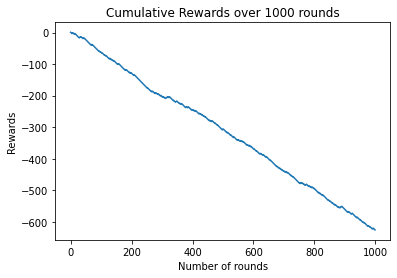

Average reward of a player after 1000 rounds is -0.626
Total rewards after 1000 rounds is -626.0


In [11]:
env.reset()
calc_payoffs(rounds = 1000, pol = draw_till_17_pol)

In [12]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation state as input and returns a vector
        of action probabilities
    """
    # an array of action probabilities
    A = np.ones(nA, dtype=float) / nA
    
    # observation refers to the state
    def policy_fn(observation):
        return A
    
    return policy_fn

In [13]:
def create_greedy_action_policy(Q):
    """ Create greedy action policy
    Args:
        env: Environment
        Q: Q table
    
    Returns:
        Greedy-action Policy function 
    """
    # observation refers to the state
    def policy_fn(observation):
       
        action_value_list = Q[observation]
        
        # get the best action
        best_action = np.argmax(action_value_list)
        
        
        
        
        P = np.zeros((len(action_value_list)), dtype = float)
       
        
        P[best_action] = 1.
        
        return P
    
    return policy_fn

In [14]:
def Off_policy_monte_carlos(num_of_episodes, policy, discount_factor):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Learn from experience, therefore, learn from the latest timestamp
    Finds an optimal greedy policy.
    
    Args:
       
        num_episodes: Number of episodes to sample.
        policy: The policy to follow while generating episodes.
                A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns action probabilities. 
        This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    # defaultdict never raises a KeyError. It provides a default value for the key that does not exists.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    # The cumulative sum of the weights for a given state with respect to the number of n returns (across all episodes)
    # store the state and action value in this dictionary to be used to 
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy based on the Q values
    target_policy = create_greedy_action_policy(Q)
    
    
    # for a range of iterations
    for episodes in range(1, num_of_episodes + 1):
        if episodes % 10000 == 0:
            print("\rEpisode {}/{}.".format(episodes, num_of_episodes), end="")
            #clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        
        
        # get multiple returns (100) for the same state
        for t in range(100):
            # Sample an action from our policy
            # get the action value (probability of taking an action) from a state using the greedy policy
            probs = target_policy(state)
            
            action = np.random.choice(np.arange(len(probs)), p=probs)
            
            next_state, reward, done, _ = env.step(action)
            #print(next_state, reward, done)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        
        """
        Get the average of the observed returns to estimate the expected returns from that state.
        More returns the agent observed from a state  = the sample average is closer to the true expected return, which is the state value.
        Returns are only observed at the end of the episode.
        """
        
        # Sum of discounted returns
        G = 0.0
        
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            
            # get the state, action, reward from a list of observations in an episode
            state, action, reward = episode[t]
            
            """
            If the action taken by the policy is not the action taken by the target policy the 
            probability will be 0 and we can break
            """
            
            if action !=  np.argmax(target_policy(state)):
                #print('break')
                #print()
                #print()
                break
                
            else:
            
            
                # Update the total reward since step t
                G = discount_factor * G + reward

                # Update weighted importance sampling formula denominator
                # cumulative weight
                #print(C)
                #print("Before adding weights: ", C[state][action])
                #print("Weights to be added: ", W)
                C[state][action] = C[state][action] + W
                #print("After adding weights: ",C[state][action])


                # Update the action-value function using the incremental update formula 
                # This also improves our target policy which holds a reference to Q
                Q[state][action] = Q[state][action] + (W / C[state][action]) * (G - Q[state][action])

                


                #print("Inital Weight: ", W)
                #print("Behaviour policy: ", policy(state)[action])
                W = W * 1./policy(state)[action]
                #print("Updated Weight", W)
                #print()
                #print()
        
    return Q, target_policy

In [15]:
initialised_policy = create_random_policy(env.action_space.n)
Q_off_Pol, off_MC_Learned_Policy = Off_policy_monte_carlos(num_of_episodes=500000, policy = initialised_policy, discount_factor = 0.9)

Episode 500000/500000.

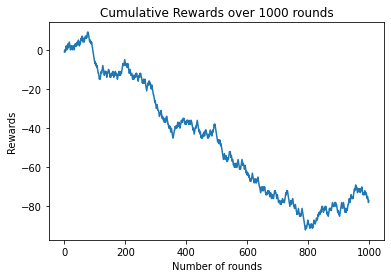

Average reward of a player after 1000 rounds is -0.077
Total rewards after 1000 rounds is -77.0


In [16]:
env.reset()
calc_payoffs(rounds = 1000, pol = off_MC_Learned_Policy)

In [17]:
def create_epsilon_greedy_action_policy(Q,epsilon):
    """ Create epsilon greedy action policy
    Args:
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action
    
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
        
        
    The on-policy method uses ε-greedy policies, meaning that most of the time, it chooses an action 
    that has maximal estimated action value, but with probability ε, it nstead select an action at random.
    
    """
    def policy(obs):
        #initiate with same prob for all actions
        # all nongreedy actions are given the minimal probability of selection
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n 
        
        #get best action
        best_action = np.argmax(Q[obs])  
        
        # probability of the greedy action
        P[best_action] = P[best_action] + (1.0 - epsilon)
        return P
    return policy

In [18]:
def On_policy_monte_carlos(episodes, discount_factor, epsilon):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        
        episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state to action values.
        Policy is the trained policy that returns action probabilities
    """
    # Keeps track of sum and count of returns for each state
    # defaultdict used so that the default value is stated if the observation(key) is not found
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(Q,epsilon)
    
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 10000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        
        for state, action in sa_in_episode:
            sa_pair = (state, action)
           
            #First Visit MC:
            # Find the first occurance of the (state, action) pair in the episode
    
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)

            
            # Sum up all rewards since the first occurance
            '''
            This discounts array is the amount by which we wanna discount each consequent reward ie.
            discounts = [1,gamma, gamma^2, gamma^3.....] 
            then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
            '''
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] = returns_sum[sa_pair] + G
            returns_count[sa_pair] = returns_count[sa_pair] + 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [19]:
Q_on_pol, On_MC_Learned_Policy = On_policy_monte_carlos(episodes = 500000, discount_factor = 0.9, epsilon = 0.05)

Episode 500000/500000.

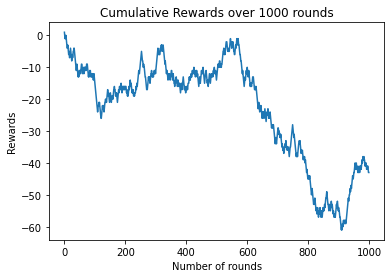

Average reward of a player after 1000 rounds is -0.043
Total rewards after 1000 rounds is -43.0


In [20]:
env.reset()
calc_payoffs(rounds = 1000, pol = On_MC_Learned_Policy)